In [3]:
import ee
import geemap
from geemap import chart

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWitPB1TQ0bPmAFygi27gUgLcdfwzSgHl6gn_-km0u-R52g66DqjLEA

Successfully saved authorization token.


In [5]:
modis = ee.ImageCollection("MODIS/006/MOD13Q1")
roi1 = ee.Geometry.Polygon(
        [[[29.554129272985683, 3.1591674847348235],
          [29.554129272985683, 3.092319151883147],
          [29.625197083044277, 3.092319151883147],
          [29.625197083044277, 3.1591674847348235]]])

ndviVis = {
  'min': 0.0,
  'max': 8000.0,
  'palette': [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ]
}

In [6]:
def create_ndvi_layers(start, end, geometry):
    images = []
    
    for year in range(start, end):
        ndvi = modis \
                .filter(ee.Filter.bounds(roi1))\
                .filter(ee.Filter.date(str(year) + '-01-01', str(year) + '-12-31')) \
                .select('NDVI') \
                .median() \
                .clip(geometry)
        
        images.append((ndvi, year))
        
    return images

In [7]:
def add_ndvi_layers(images, geometry):
    Map = geemap.Map()
    Map.centerObject(geometry, 12)
    
    for image, year in images:
        Map.addLayer(image, ndviVis, 'NDVI ' + str(year))
        
    return Map

In [8]:
Map = add_ndvi_layers(create_ndvi_layers(2004, 2020, roi1), roi1)
Map

Map(center=[3.1257435633122834, 29.589663178011996], controls=(WidgetControl(options=['position', 'transparent…

In [9]:
def extract_data(image):
    stats = image.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': image.geometry(),
        'scale': 10
    })
    
    properties = {
        'Year': image.get('system:index'),
        'NDVI': stats.get('NDVI'),
    }
    
    return ee.Feature(None, properties)

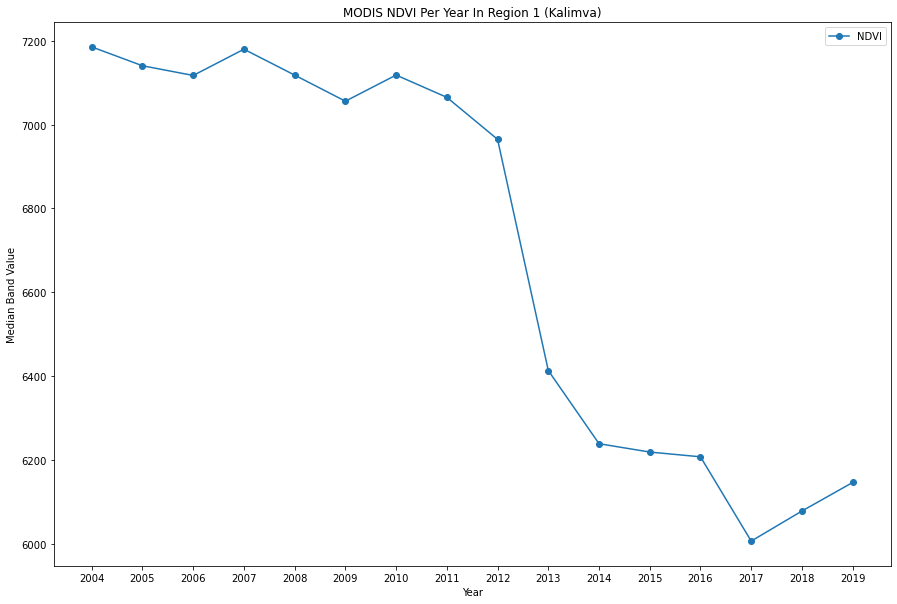

In [10]:
images = ee.ImageCollection(create_ndvi_layers(2004, 2020, roi1))
data = ee.FeatureCollection(images.map(extract_data))
df = geemap.ee_to_pandas(data)
images = create_ndvi_layers(2004, 2020, roi1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)

xticks = [t[1] for t in images]
ax.set_xticks([i for i in range(16)], xticks)

df.plot(ax=ax,
       title = 'MODIS NDVI Per Year In Region 1 (Kalimva)',
       xlabel='Year',
       ylabel='Median Band Value',
       marker='o')

plt.show()